*Copyright (C) 2021 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

## Quadratic Programming with Lava

This tutorial covers how to use the Quadratic Program (QP) Solver developed in Lava to solve QPs and demonstrates their use in larger process-based lava applications.

### Recommended Tutorials before starting

- [Installing Lava](https://github.com/lava-nc/lava/blob/main/src/lava/tutorials/in_depth/tutorial01_installing_lava.ipynb)
- [Processes](https://github.com/lava-nc/lava/blob/main/src/lava/tutorials/in_depth/tutorial02_processes.ipynb "Tutorial on Processes")
- [ProcessModel](https://github.com/lava-nc/lava/blob/main/src/lava/tutorials/in_depth/tutorial03_process_models.ipynb "Tutorial on ProcessModels")
- [Execution](https://github.com/lava-nc/lava/blob/main/src/lava/tutorials/in_depth/tutorial04_execution.ipynb "Tutorial on Executing Processes")

### A QP solver on Loihi

The fixed-point architecture of the Loihi can nessecitates inversion-free algorithms and therefore we employ first-order iterative algorithms. Towards this, we use an update scheme that is conducive for Loihi. The update scheme consists of two steps, namely, gradient descent and constraint-correction. The gradient descent evolves in the unconstrained space of the QP and the constraint-correction after the constraint-check ensures that the gradient dynamics evolve in the feasible region of the QP. Consider the following QP,
$$ \text{argmin} \frac{1}{2}x^TQx + p^Tx $$
$$ \text{s.t.  } Ax \le k,$$ 
where $ x \in \mathbb{R}^n$, $ Q \in \mathbb{S}_{+}^{n \times n}$, $ p \in \mathbb{R}^n$ , $ A \in \mathbb{R}^{m \times n} $ and $ k \in \mathbb{R}^m$ where $m$ and $n$ are integers. This can be solved with the following first-order iterative update scheme,

$$ x_{i+1} = -\alpha_i (Qx_i + p) - \beta_i A^T\delta_G(x_i)$$

$$ \delta_G(x_i) = \left\{\begin{array}{lr}
        Ax_i-k, & \text{for } Ax_i \geq k\\
            0, & \text{for } Ax_i \leq k\\
        \end{array}\right\},  $$

where $i$ is some integer representing the iteration number, $\alpha_i$ is the learning rate and $\beta_i$ is the constraint-correction rate. $\delta_G$ is a "graded spike" which Loihi 2 supports. Note that equality constraints can be expressed as sandwiched inequality constraints.

## The LASSO problem as an LCA

Consider the (Least Absolute Shrinkage and Selection Operation) LASSO problem,
$$ \text{argmin } \frac{1}{2}||Px - q||_2^2 $$
$$ \text{s.t.  } ||x||_1 \leq \tau,$$ 
where $ x \in \mathbb{R}^n$, $ P \in \mathbb{R}^{n \times n}$, $ q \in \mathbb{R}^n$ , where $\tau$ is some constant. It has been shown that the LCA dynamics in principle solve a LASSO problem. The LASSO problem can be rewritten as an exponential QP of the following form. 
$$ \text{argmin } \frac{1}{2}||Px - q||_2^2 $$
$$ \text{s.t.  } a_i^Tx_i \leq \tau, \forall i$$ 
where $a_i$ are all $2^n$ vectors of $+1$ or $-1$.

The exponential QP can be further expressed as:
$$ \text{argmin } \frac{1}{2}x^TQx + p^Tx$$
$$ \text{s.t.  } a_i^Tx_i \leq \tau, \forall i$$ 
where $Q = P^TP$ , $p= -P^Tq$. We ignore the constant term as it does not affect the solution of the QP.


### Problem Setup 

In [1]:
# Import the QP solver and Problem classes
import numpy as np
from lava.lib.optimization.problems.problems import QP
from lava.lib.optimization.solvers.qp.solver import QPSolver

Consider the LASSO problem with the following values

In [2]:
P = np.array([[30, 10, 2], [10, 3, 2], [10, 20, 5]])
q = np.array([[1, 2, 1]]).T
tau = 10

We now rewrite the LASSO problem as a QP  and feed it to our solver. Note that the solver does some preconditioning before applying the first-order algorithm explained above. Preconditioning is problem dependant and finding the right preconditioner is dependant on the class of problems being solved. Ideally a preconditioner should be simple to compute and decrease the number of iterations to solution. <br>
The parameters `alpha` and `beta` determine the speed of convergence to the solution. `alpha_d` and `beta_g` are the timesteps after which `alpha`/`beta` are decreased/increased via a right/left shift.

In [3]:
## setting up the LASSO problem
Q = P.T@P
p = -P.T@q
A = np.array([[-1, -1,  1], 
              [-1,  1, -1],
              [-1,  1,  1],
              [ 1, -1, -1],
              [ 1, -1,  1],
              [ 1,  1, -1],
              [ 1,  1,  1],
              [-1, -1, -1],
             ])
k = tau*np.ones((1,8)).T

## Learning constants for the solver
alpha_d, beta_g = 10000, 10000

To use a first-order solver, make sure that your problem is properly preconditioned very high condition numbers can lead to inaccurate solutions or converge extremely slowly. We precondition this problem in the following manner using a simple diagonal preconditioner,

In [4]:
pre_mat_Q = np.diag(1/np.linalg.norm(Q, axis=1))
Q_pre = pre_mat_Q@Q@pre_mat_Q
p_pre = pre_mat_Q@p
alpha = 100

In [5]:
np.linalg.cond(Q), np.linalg.cond(Q_pre)

(843.2035150764788, 89.69603745921796)

We can see above that the condition number of the matrix, $Q$, has considerably decreased after preconditioning. The max eigenvalue of `Q_pre` usually determines have high the intial value of `alpha` can be.<br>
Further, if the constraints are preconditioned in a row-wise l-2 norm manner, we can set $\beta = 1$. 

In [6]:
pre_mat_A = np.diag(1/np.linalg.norm(A, axis=1))
A_pre = pre_mat_A@A@pre_mat_Q
k_pre = pre_mat_A@k
beta = 1

### Solving the QP with Lava: Simple Solver Interface

The code snippet below shows the solver interface that can be used in lava similar to most standard QP interfaces. We define a `problem` of class `QP` and then feed to the solver routine, `solve`, to get the solution to the QP.

In [7]:
# Arguments to solver Q, p, A, k, A_eq, k_eq
problem = QP(Q_pre, p_pre, A_pre, k_pre)
solver = QPSolver(
    alpha=alpha,
    beta=beta,
    alpha_decay_schedule=alpha_d,
    beta_growth_schedule=beta_g,
    )
sol = solver.solve(problem, iterations=1000)

In [8]:
pre_mat_Q@sol

array([[ 0.04280751],
       [-0.24503804],
       [ 1.09806917]])

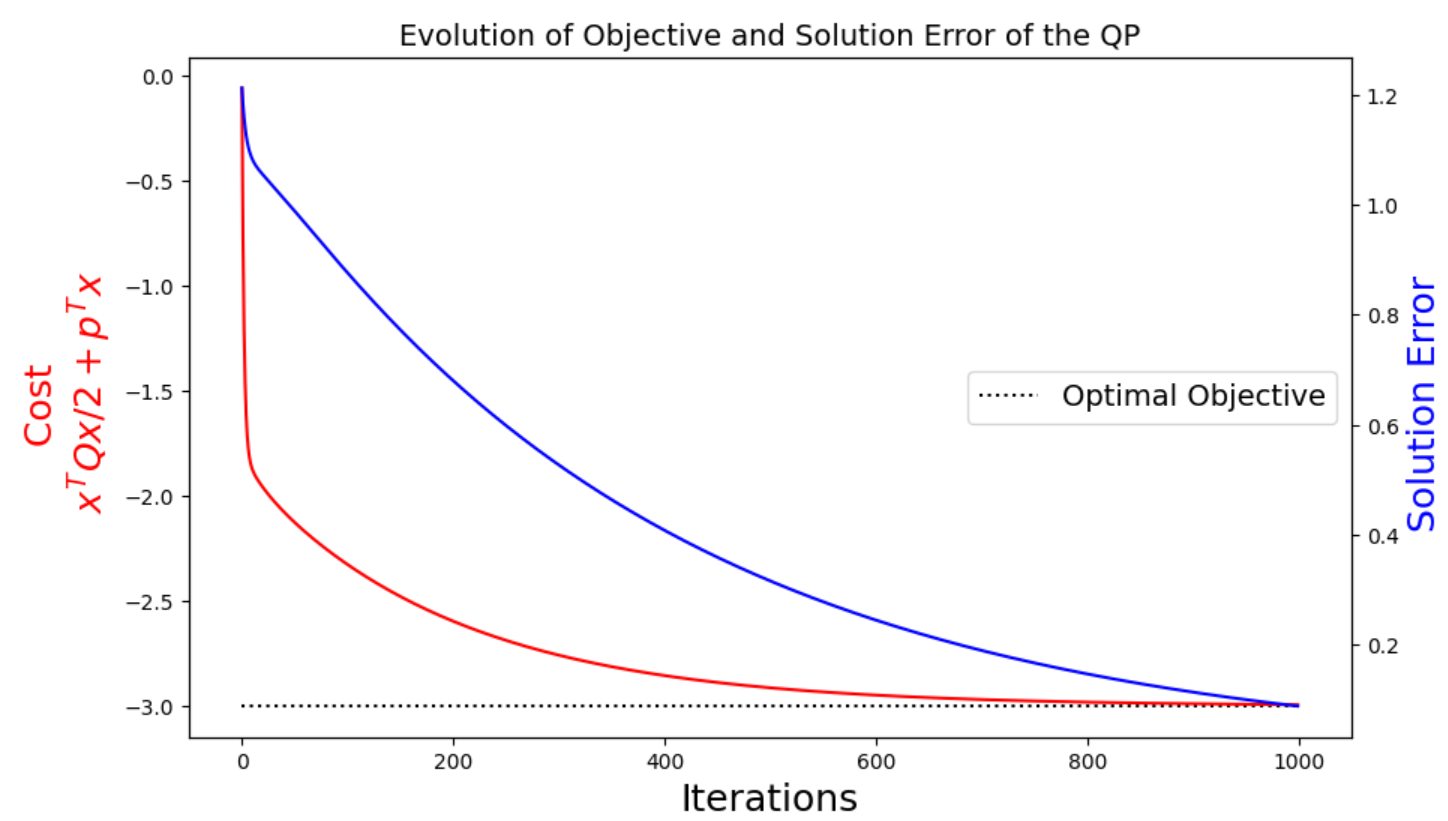

Note that the actual solution to this problem is $(0.0436, -0.267, 1.183)$ which is close to the solution obtained above given that the solver starts from a random intial value. Thus, the neuromorphic QP solver demonstrates convergent behavior. In the above example, a constant value of `alpha` was used. Using a decaying `alpha` and a larger number of iterations could further increase the accuracy of the solver. 

## Solving the QP with Lava: Application

We shall now see what the solver interface has abstracted to the user. The QP solver has mainly two heirarchical processes whose behaviors are defined by the behaviors of their subprocesses. The GradientDynamics process houses the ConstraintNormals, QuadraticConnectivity and SolutionNeurons subprocesses.  The ConstraintCheck process contains the ConstraintDirection and ConstraintCheck processes.<br>
As a consequence of this, the QP solver works merely by connecting the two processes together and initiating the run command. The process diagram of the QP solver is shown below. 

In [9]:
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.lib.optimization.solvers.qp.models import (
    ConstraintCheck,
    GradientDynamics,
)

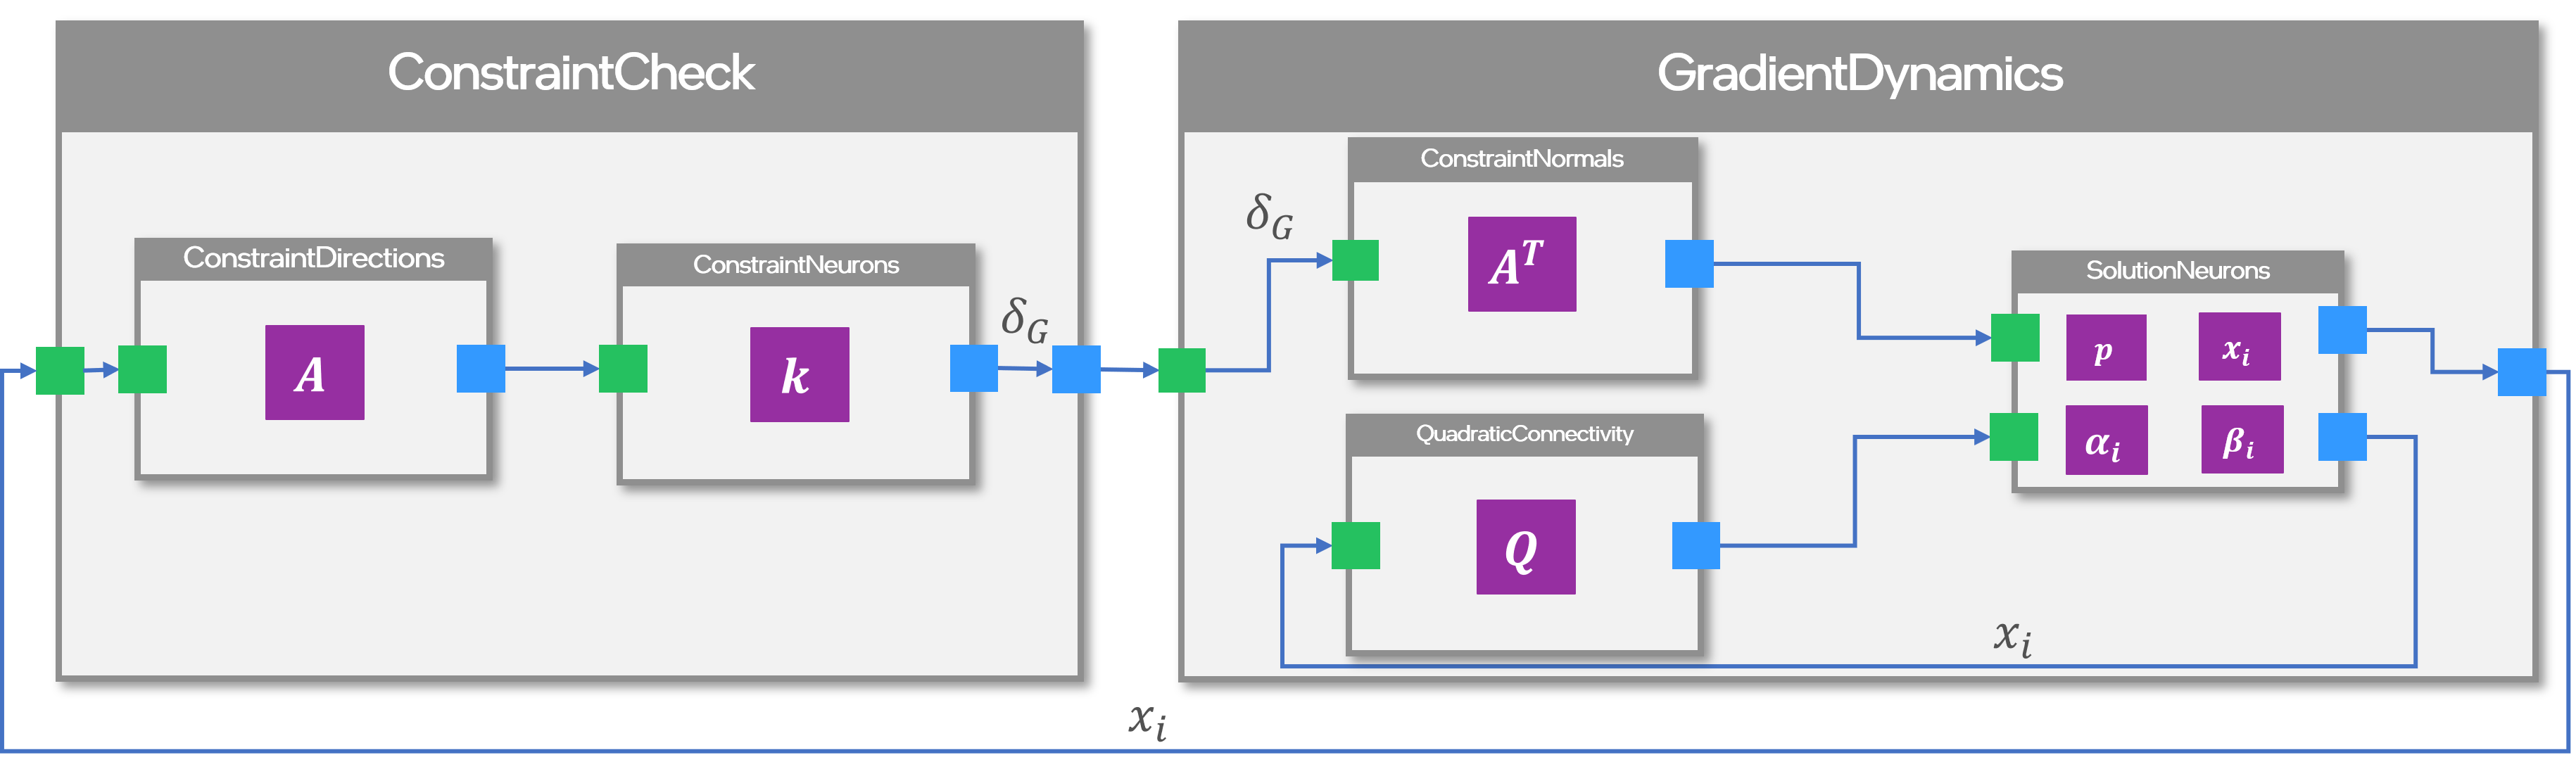

The above QP solver processes can be used in a sytem of interconnected processes that cater to a an application e.g: Model Predictive Control (MPC) or Invariant Object Detection. Let us look at how we could utilize the QP solver process in MPC.<br>
Consider the cost function of a system for a particular iteration, $k$,  of the MPC as shown below,

$$    \text{argmin}_{\{\Delta x_t\}, \{\Delta u_t \}} \Sigma^{N-1}_{t=0} \frac{1}{2} (\Delta x_t^T Q_t \Delta x_t + 2\Delta x_t^TP_t\Delta u_t + \Delta u_t^T R_t \Delta u_t + q_t^T \Delta x_t + r_t^T \Delta u_t) + \frac{1}{2}(\Delta x_t^T Q_N \Delta x_t + \Delta x_N^T q_N)
$$
$$
\text{subject to  } \\ \Delta x_0 = \Delta \bar{x_0} \\ \Delta x_{t+1} = A_t \Delta x_t + B_t \Delta u_t  \forall t = 0,..., N-1
$$


The cost of  MPC can be reformulated as a QP of the following form 
$$ \text{argmin} \frac{1}{2}y^TH_ky + h_k^Ty $$
$$ \text{s.t.  } G_ky = g_k,$$
For the $ {k+1^{th}} $ iteration of the MPC, the matrices and vectors of the QP would have to be modified to solve a new QP that corresponds to the cost of the $ {k+1^{th}} $ iteration of the MPC. we shall shall see below how we accomplish this in Lava.

Let us now assume to have data from two iterations of an MPC as follows:

### MPC iteration k Data

In [10]:
H_0 = np.array([[300, 0, 0],
              [0, 1, 0],
              [0,   0, 5]])

h_0 = np.array([[1, 2, 1]]).T

G_0 =  np.array([[1,2, 2],
               [2, 1, 3]])

g_0 = np.array([[-50, 50]]).T    


# Rewrite the each equality constraint as two inquality constraints
G_0_new = np.vstack((G_0,-G_0))
g_0_new = np.vstack((g_0,-g_0))

pre_mat_H_0 = np.diag(1/np.linalg.norm(H_0, axis=1))
H_0_pre = pre_mat_H_0@H_0@pre_mat_H_0
h_0_pre = pre_mat_H_0@h_0

pre_mat_G_0 = np.diag(1/np.linalg.norm(G_0_new, axis=1))
G_0_pre = pre_mat_G_0@G_0_new@pre_mat_H_0
g_0_pre = pre_mat_G_0@g_0_new

### MPC Iteration k+1 Data

In [11]:
H_1 = np.array([[100, 0, 0],
              [0, 20, 0],
              [0,   0, 5]])

h_1 = np.array([[1, 0, 1]]).T

G_1 =  np.array([[2,1, 1],
               [5, 3, 1]])

g_1 = np.array([[-50, 50]]).T    


# Rewrite the each equality constraint as two inquality constraints
G_1_new = np.vstack((G_1,-G_1))
g_1_new = np.vstack((g_1,-g_1))

pre_mat_H_1 = np.diag(1/np.linalg.norm(H_1, axis=1))
H_1_pre = pre_mat_H_1@H_1@pre_mat_H_1
h_1_pre = pre_mat_H_1@h_1

pre_mat_G_1 = np.diag(1/np.linalg.norm(G_1_new, axis=1))
G_1_pre = pre_mat_G_1@G_1_new@pre_mat_H_1
g_1_pre = pre_mat_G_1@g_1_new

## Running MPCs in Lava

We now run the MPC based on the data that we generated in the previous section. We initialize the processes of the QP first with the matrices from the $ k^{th} $ iteration of the MPC

In [12]:
init_sol = np.random.rand(Q_pre.shape[0], 1)
iterations = 1000
alpha_d, beta_g = 10000, 10000
alpha, beta = 0.0005, 1

# Initialize the ConstraintCheck Process of the QP
ConsCheck = ConstraintCheck(constraint_matrix=G_0_pre,
                            constraint_bias=g_0_pre,
                            )

# Initialize the Gradient Dynamics process of the QP
GradDyn = GradientDynamics(hessian=H_0_pre, 
                           constraint_matrix_T=G_0_pre.T,
                           qp_neurons_init=init_sol, 
                           grad_bias=h_0_pre, alpha=alpha, 
                           beta=beta, 
                           alpha_decay_schedule=alpha_d,
                           beta_growth_schedule=beta_g,
                           )

The processes are then connected and run to get the solution of the $k^{th}$ iteration of the MPC

In [13]:
# Connect the two hierarchical processes to form core QP 
# solver
GradDyn.a_out.connect(ConsCheck.s_in)
ConsCheck.a_out.connect(GradDyn.s_in)

# Enable select_sub_proc_model to run subprocess models
GradDyn.run(condition=RunSteps(num_steps=iterations),
            run_cfg=Loihi1SimCfg(select_sub_proc_model=True)
           )
# get solution of kth iteraation of MPC 
pre_sol_k = GradDyn.vars.qp_neuron_state.get()

We then move to the next iteration the MPC by setting the new matrices for the problem

In [14]:
# Initialize with matrices for the k+1th iteration of the MPC
GradDyn.vars.hessian.set(H_1_pre)
GradDyn.vars.constraint_matrix_T.set(G_1_pre.T)
GradDyn.vars.grad_bias.set(h_1_pre)
ConsCheck.vars.constraint_matrix.set(G_1_pre)
ConsCheck.vars.constraint_bias.set(g_1_pre)

# Run solver dynamics for new problem
GradDyn.run(condition=RunSteps(num_steps=iterations),
            run_cfg=Loihi1SimCfg(select_sub_proc_model=True)
           )

# get solution of k+1th iteraation of MPC 
pre_sol_k_1 = GradDyn.vars.qp_neuron_state.get()

# stop process execution
GradDyn.stop()

# postconditioning to get actual solution
sol_k = pre_mat_H_0@pre_sol_k
sol_k_1 = pre_mat_H_1@pre_sol_k_1

In [17]:
print("Solution of the  kth MPC is {} and k+1th iteration is {}".format(sol_k.T, sol_k_1.T))

Solution of the  kth MPC is [[ 1.02421108e-02 -6.17557312e+01  3.69568762e+01]] and k+1th iteration is [[ 3.32294059e-02 -3.08797782e+00  3.69593551e+01]]


Going by the design in this notebook, the QP solver is an interplay between two lava processes, namely, GradientDynamics and ConstraintCheck. The modularity of lava allows one to connect these processes seamlessly to other processes running as a part of a larger system. This can be visualized as below:

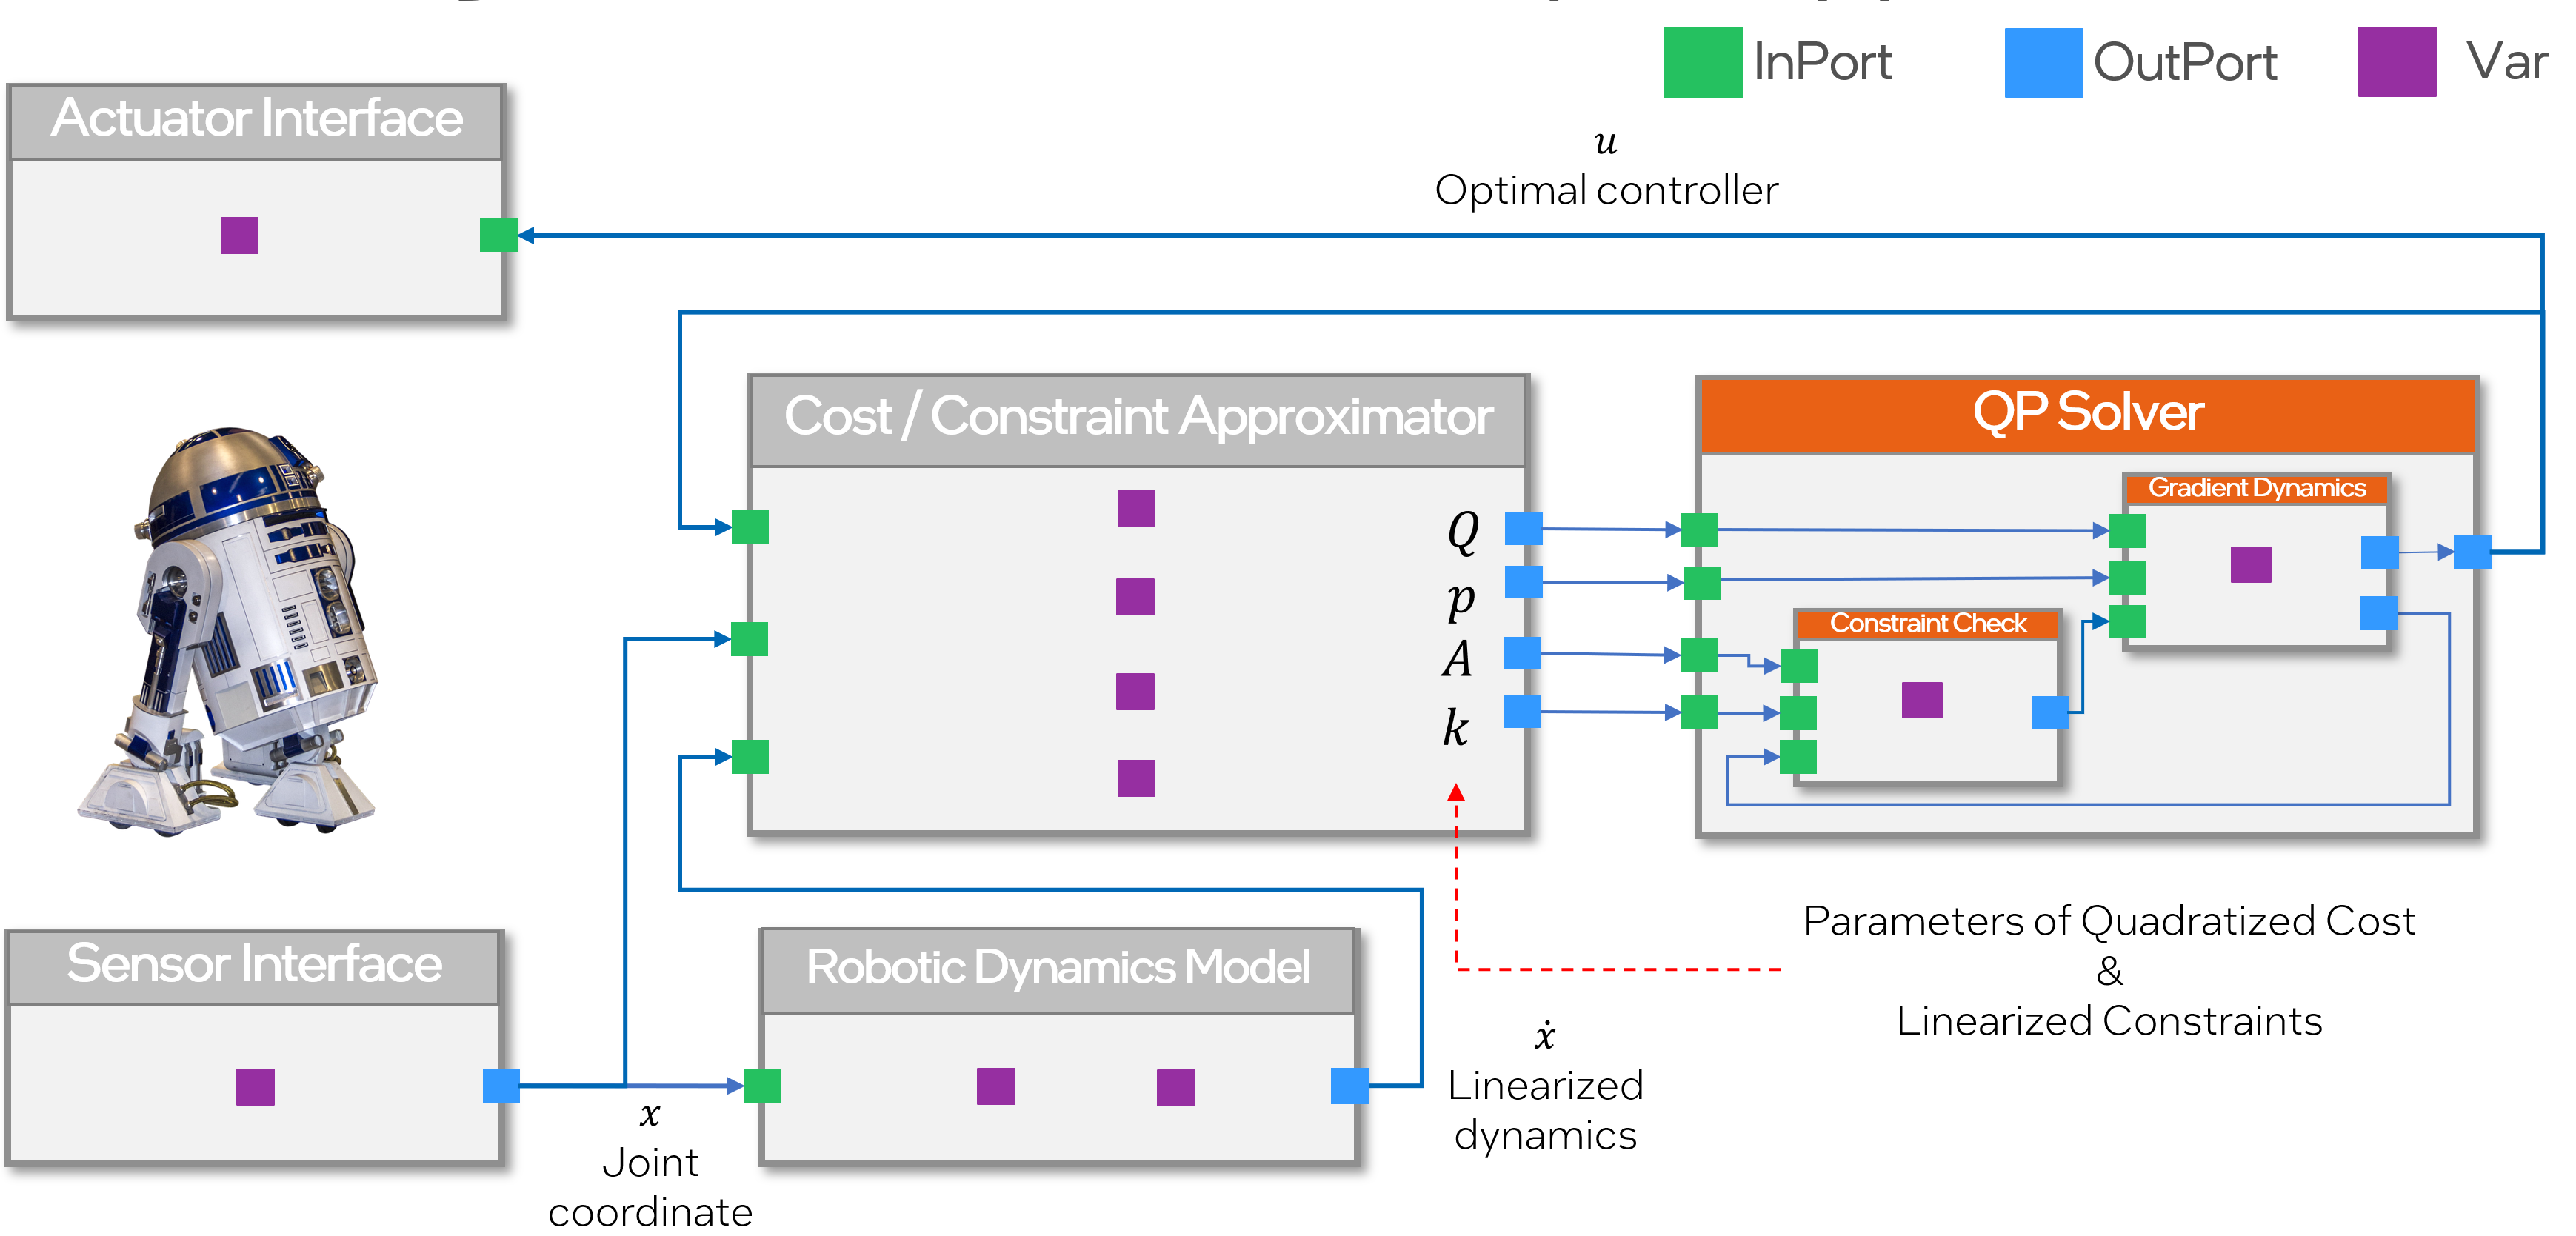

### Future features 

- Loihi uses Fixed-point arithmetic with limited precision to perform arithmetic operations. Support for this will be added to the solver simulator in a future release. 
- A dedicated LCA solver with convolutional layer support will be added to the toolbox in a future release.

### How to learn more?

Watch this [space](https://github.com/lava-nc/lava-optimization) to learn about upcoming developments to the QP solver and the optimization toolbox in Lava in general. 

If you want to find out more about the implementation of the QP solver, have a look at the [Lava documentation](https://lava-nc.org/ "Lava Documentation") or dive into the [source code](https://github.com/lava-nc/lava-optimization/tree/main/src/lava/lib/optimization/solvers/qp
"QP source code").
To receive regular updates on the latest developments and releases of the Lava Software Framework please subscribe to the [INRC newsletter](http://eepurl.com/hJCyhb "INRC Newsletter").